## Kaggle Compettion Submission File
### Matt Johnescu
### Competition: Binary Prediction of Poisonous Mushrooms
#### Primary Challenges:
#### - Data Cleaning
#### - Producing a model with high predictive accuracy

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
import joblib

# Set random seed and other parameters
SEED = 12
n_splits = 10


In [26]:
train_data = pd.read_csv("C:/Users/matt/Downloads/playground-series-s4e8/train.csv")
test_data = pd.read_csv("C:/Users/matt/Downloads/playground-series-s4e8/test.csv")


# Display the first few rows of each dataframe
print(train_data.head())
print(test_data.head())

# Store the 'id' column separately and drop it from the dataset
train_id = train_data['id']
test_id = test_data['id']
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       

### Data Exploration

In [ ]:
# Function to check basic data statistics, null values, and unique values
def checking(df):
    total = len(df)
    null_df = pd.DataFrame(df.isnull().sum(), columns=['#NULLS'])
    null_df['%NULLS'] = round((null_df['#NULLS'] / total) * 100, 5)
    null_df['#Unique_Values'] = df.nunique()
    
    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    uniques = []
    for col in df.columns:
        if col in cat_cols:
            uniques.append(set(df[col].dropna()))
        else:
            uniques.append(df[col].max() - df[col].min())
    null_df['Unique_Values'] = uniques
    return null_df

# Checking the train and test datasets
print("Train Data Overview")
print(checking(train_data))

print("\nTest Data Overview")
print(checking(test_data))

<Figure size 1200x800 with 0 Axes>

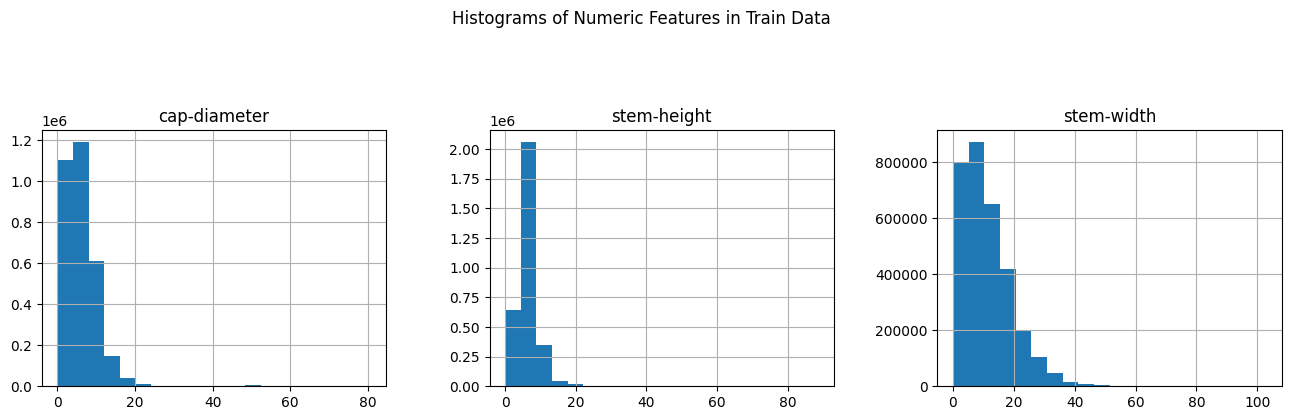

In [27]:
# Histograms of numeric features
numeric_features = train_data.select_dtypes(include=['float64', 'int64' ]).columns
plt.figure(figsize=(12, 8))
train_data[numeric_features].hist(bins=20, figsize=(16, 12), layout=(3, 3))
plt.suptitle("Histograms of Numeric Features in Train Data")
plt.show()

In [ ]:
# Function to detect outliers
def outliers_detection(df, q1_coef=0.25, q3_coef=0.75):
    data_out = df.copy()
    outlier_counts = {}

    num_cols = [col for col in data_out.columns if data_out[col].dtype != 'object']

    for col in num_cols:
        q1 = data_out[col].quantile(q1_coef)
        q3 = data_out[col].quantile(q3_coef)
        iqr = q3 - q1
        outlier_counts[col] = len(data_out[(data_out[col] < q1 - 1.5 * iqr) | (data_out[col] > q3 + 1.5 * iqr)])
    
    return outlier_counts

# Detecting outliers in the training data
outliers = outliers_detection(train_data)
print("Outliers detected in each column:")
print(outliers)


In [ ]:
# Pairplot visualization of selected features
selected_features = ['cap-diameter', 'stem-height', 'stem-width', 'class']
sns.pairplot(train_data[selected_features], hue='class')
plt.show()


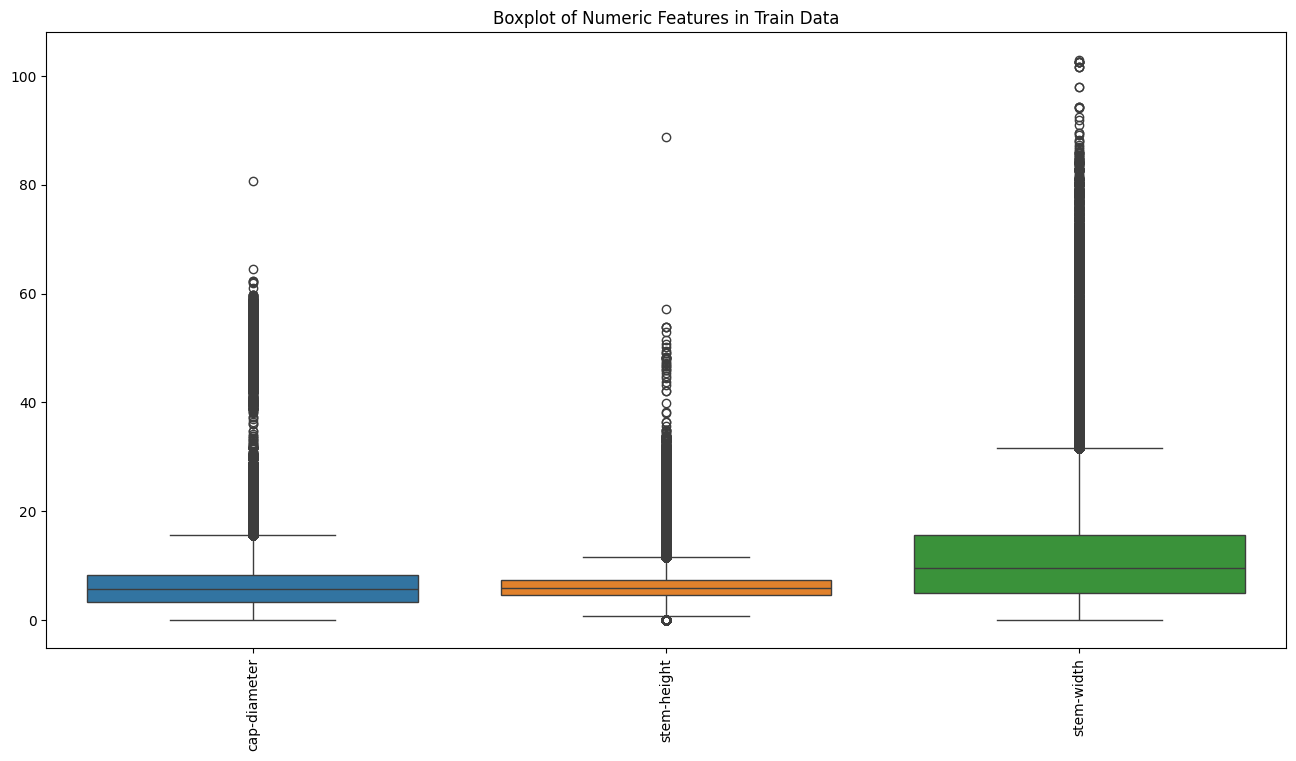

In [28]:
# Boxplot to check for outliers
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data[numeric_features])
plt.title("Boxplot of Numeric Features in Train Data")
plt.xticks(rotation=90)
plt.show()

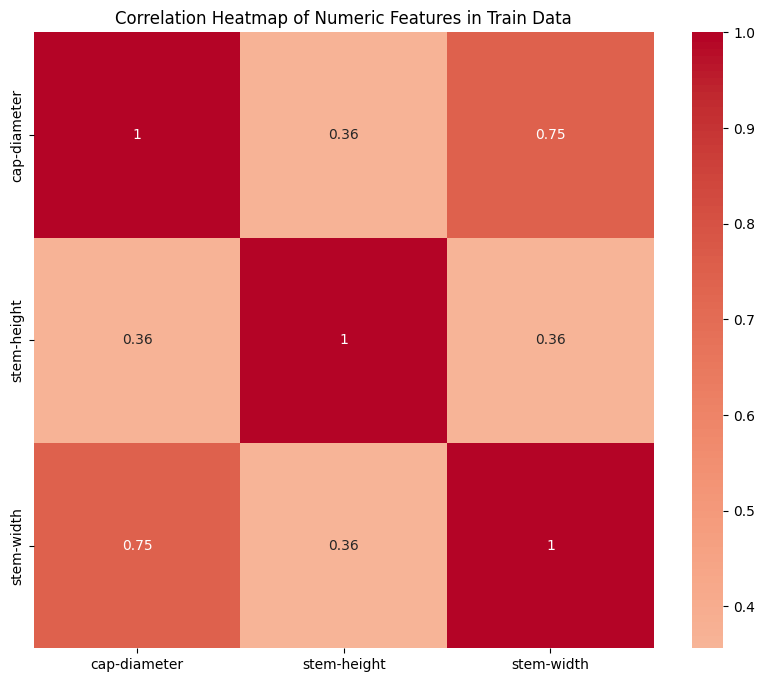

In [29]:
# Correlation heatmap of numeric features
plt.figure(figsize=(10, 8))
corr_matrix = train_data[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numeric Features in Train Data")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Example clustering with K-Means
features_for_clustering = ['cap-diameter', 'stem-height', 'stem-width']
X = train_data[features_for_clustering].fillna(0)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Visualize clustering results
sns.scatterplot(x='cap-diameter', y='stem-height', hue=kmeans_labels, data=train_data)
plt.title('K-Means Clustering')
plt.show()


### Cleaning and Pre-processing

In [31]:
# After processing, add the 'id' column back to the datasets
train_data['id'] = train_id
test_data['id'] = test_id

# Data Cleaning and Preprocessing
def handle_missing_values(train, test, seed=None):
    num_c = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
    cat_c = [col for col in train.columns if train[col].dtype == 'object']
    if 'class' in cat_c:
        cat_c.remove('class')
    
    I = IterativeImputer(random_state=seed)
    train[num_c] = I.fit_transform(train[num_c])
    test[num_c] = I.transform(test[num_c])
    
    for col in cat_c:
        train[col].fillna('No_Record', inplace=True)
        if col in test.columns:
            test[col].fillna('No_Record', inplace=True)
    
    return train, test, cat_c

def align_columns(train, test):
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    return train, test


In [32]:
# Apply missing value handling and align train/test columns
train_data, test_data, cat_cols = handle_missing_values(train_data, test_data, seed=SEED)
target = train_data['class']
train_features = train_data.drop(columns=['class'], errors='ignore')
train_features_aligned, test_features_aligned = align_columns(train_features, test_data)

C:\Users\matt\AppData\Local\Temp\ipykernel_17276\2981818369.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna('No_Record', inplace=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_17276\2981818369.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [33]:
# Encode categorical features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_features_encoded = encoder.fit_transform(train_features_aligned)
test_features_encoded = encoder.transform(test_features_aligned)

### Setting Up Model

In [35]:
# Model Training with XGBoost
def Train_ML(Model, X, y, test_data):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    train_scores = []
    val_scores = []
    test_predictions = [] 
    models = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        model = Model
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_mcc = matthews_corrcoef(y_train, y_train_pred)
        train_scores.append(train_mcc)

        y_val_pred = model.predict(X_val)
        val_mcc = matthews_corrcoef(y_val, y_val_pred)
        val_scores.append(val_mcc)
        
        y_test_pred_proba = model.predict(test_data)
        test_predictions.append(y_test_pred_proba)
        
        models.append(model)

        print(f"Fold {fold}: Train MCC = {train_mcc:.6f}, Validation MCC = {val_mcc:.6f}")

    mean_train_mcc = np.mean(train_scores)
    mean_val_mcc = np.mean(val_scores)
    print(f"\nMean Train MCC: {mean_train_mcc:.6f}")
    print(f"Mean Validation MCC: {mean_val_mcc:.6f}")

    return model, test_predictions


In [36]:
# Set XGBoost parameters
Xparams_s1 = {
    'n_estimators': 1396, 'max_depth': 19, 'learning_rate': 0.010455050159676566, 'subsample': 0.8006842727555243, 
    'colsample_bytree': 0.5001438770455072, 'colsample_bylevel': 0.8027576507794217, 'min_child_weight': 5,
    'reg_alpha': 1.1586967014672253e-08, 'reg_lambda': 3.3517458803447213e-06, 'gamma': 0.01841032988451454
}


In [40]:
from sklearn.preprocessing import LabelEncoder
# Convert target_encoded to a Pandas Series
target_encoded = pd.Series(target_encoded)

# Now use `target_encoded` instead of `target` in your model training
xgb_model, xgb_preds = Train_ML(xgb_model, pd.DataFrame(train_features_encoded), target_encoded, pd.DataFrame(test_features_encoded))


# Encode the target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Now use `target_encoded` instead of `target` in your model training
xgb_model, xgb_preds = Train_ML(xgb_model, pd.DataFrame(train_features_encoded), target_encoded, pd.DataFrame(test_features_encoded))


# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**Xparams_s1, random_state=SEED, tree_method='hist', use_label_encoder=False)
xgb_model, xgb_preds = Train_ML(xgb_model, pd.DataFrame(train_features_encoded), target, pd.DataFrame(test_features_encoded))


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1: Train MCC = 0.987929, Validation MCC = 0.984971


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2: Train MCC = 0.987934, Validation MCC = 0.984366


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3: Train MCC = 0.987934, Validation MCC = 0.984441


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4: Train MCC = 0.987894, Validation MCC = 0.984946


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5: Train MCC = 0.987932, Validation MCC = 0.984988


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 6: Train MCC = 0.987869, Validation MCC = 0.985484


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 7: Train MCC = 0.987953, Validation MCC = 0.984779


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 8: Train MCC = 0.987962, Validation MCC = 0.984741


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 9: Train MCC = 0.987941, Validation MCC = 0.984740


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 10: Train MCC = 0.987986, Validation MCC = 0.984571

Mean Train MCC: 0.987933
Mean Validation MCC: 0.984803


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
# Save the trained model
joblib.dump(xgb_model, 'xgb_model_final.pkl')


### Submission

In [ ]:
# Prepare the submission file
xgb_test = np.mean(xgb_preds, axis=0)
xgbpreds = (xgb_test >= 0.5).astype(int)
x_f = encoder.inverse_transform(xgbpreds.reshape(-1, 1)).flatten()

sub_F = pd.DataFrame({
    'id': test_data['id'],
    'class': x_f
})

sub_F.to_csv('submission_final.csv', index=False)
print(sub_F.head())